Ли-Зан-Мен Сергей lizanmensergej@gmail.com

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
sns.set(
    style='whitegrid',
    rc={'figure.figsize': (8, 4)}
)

In [3]:
train_df = pd.read_csv('train.csv')
players_df = pd.read_csv('players_feats.csv')
test_df = pd.read_csv('test.csv', index_col=0)

In [4]:
RANDOM_STATE = 2
N_FOLDS = 3
VAL_SIZE = 0.25
EPS = 1e-18



# Чтобы быстро проверить работоспособность можно выставить маленькое значение
N_PARAMS = 10_000

# 1. mini EDA

In [5]:
train_df.shape

(713, 5)

In [6]:
train_df.head()

,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1
3,524,4608,7532,Mirage,0
4,404,8637,6667,Overpass,1


In [7]:
players_df.describe().transpose().tail(40)

,count,mean,std,min,25%,50%,75%,max
p4_saved_by_teammate_per_round,1486.0,0.084960,0.025369,0.0,0.070,0.08,0.100,0.22
p4_saved_teammates_per_round,1486.0,0.093560,0.027579,0.0,0.080,0.09,0.110,0.22
p4_rating,1486.0,1.094004,0.158174,0.0,1.020,1.10,1.180,1.70
p4_kill_death,1486.0,1.057860,0.304153,0.0,0.940,1.07,1.210,2.04
p4_kill_round,1486.0,0.654684,0.164165,0.0,0.610,0.68,0.740,1.10
p4_rounds_with_kills,1486.0,138.555855,78.003250,0.0,84.000,138.00,185.750,399.00
p4_kill_death_difference,1486.0,18.299462,35.498278,-68.0,-6.000,10.00,39.000,152.00
p4_total_opening_kills,1486.0,31.349260,20.094788,0.0,17.000,29.00,43.000,116.00
p4_total_opening_deaths,1486.0,26.226110,17.584429,0.0,13.000,24.00,36.000,136.00
p4_opening_kill_ratio,1486.0,1.280464,0.759561,0.0,0.840,1.15,1.560,9.33


In [8]:
na_df = players_df.isna().sum()
na_df[na_df > 0]

p1_team_win_percent_after_first_kill    3
p2_team_win_percent_after_first_kill    3
p3_team_win_percent_after_first_kill    4
p4_team_win_percent_after_first_kill    4
p5_team_win_percent_after_first_kill    4
dtype: int64

# 2. Baseline

In [9]:
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

In [10]:
features = pd.merge(train_df, players_df.drop('map_name', axis=1), how='left', 
         left_on=['map_id', 'team1_id'], right_on=['map_id', 'team_id'])

features = pd.merge(features, players_df.drop('map_name', axis=1), how='left', 
         left_on=['map_id', 'team2_id'], right_on=['map_id', 'team_id'], suffixes=['_1', '_2'])

In [11]:
features.head()

,map_id,team1_id,team2_id,map_name,who_win,p1_id_1,p1_total_kills_1,p1_headshots_1,p1_total_deaths_1,p1_kd_ratio_1,...,p5_kill_round_2,p5_rounds_with_kills_2,p5_kill_death_difference_2,p5_total_opening_kills_2,p5_total_opening_deaths_2,p5_opening_kill_ratio_2,p5_opening_kill_rating_2,p5_team_win_percent_after_first_kill_2,p5_first_kill_in_won_rounds_2,team_id_2
0,289,6665,7718,Ancient,0,4954,258,36.0,293,0.88,...,0.55,75,-34,21,20,1.05,1.06,76.2,19.0,7718
1,715,4411,10577,Inferno,0,8611,178,39.3,208,0.86,...,0.78,197,90,64,25,2.56,1.39,75.0,23.3,10577
2,157,11251,9455,Nuke,1,7938,494,52.8,397,1.24,...,0.55,101,-32,32,35,0.91,1.09,53.1,15.5,9455
3,524,4608,7532,Mirage,0,7998,474,29.1,304,1.56,...,0.54,109,-13,15,21,0.71,0.82,73.3,7.9,7532
4,404,8637,6667,Overpass,1,2898,217,55.8,248,0.88,...,0.72,122,26,20,10,2.00,1.01,80.0,12.4,6667


Т.к. данных для обучения мало, ставим пониже lr, также не нужно большое число деревьев 

In [12]:
def train_xgb_with_grid(X=None, y=None, params={}, cv=None, fit_params={}, n_iter_random=None, 
                        X_train=None, X_val=None, y_train=None, y_val=None):
    if cv is None:
        cv = StratifiedKFold(n_splits=N_FOLDS, random_state=RANDOM_STATE, shuffle=True)
    if any(obj is None for obj in [X_train, X_val, y_train, y_val]):
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=RANDOM_STATE, test_size=VAL_SIZE, stratify=y)

    if not params:
        params = {
            'learning_rate': [0.001, 0.005, 0.01, 0.03],
            'n_estimators': [10, 20, 50],
            'max_depth': np.arange(3, 6, 2),
            'subsample': [0.5, 0.75, 1],
            'reg_alpha': [0, 0.1, 0.5, 1, 5],
            'reg_lambda': [0, 0.1, 0.5, 1, 5],
            'gamma': [0, 0.5, 1]
        }
        
    if not fit_params:
        fit_params={
            'eval_set' : [[X_train, y_train], [X_val, y_val]],
            'verbose': 0
        }
    
    xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='auc', early_stopping_rounds=None, 
                              random_state=RANDOM_STATE)
    
    if n_iter_random is None:
        grid_xgb = GridSearchCV(xgb_model, params, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)
    else:
        grid_xgb = RandomizedSearchCV(xgb_model, params, cv=cv, scoring='roc_auc',
                             n_iter=n_iter_random, verbose=1, n_jobs=-1, random_state=RANDOM_STATE)
    grid_xgb.fit(X_train, y_train, **fit_params)
    
    return X_train, X_val, y_train, y_val, grid_xgb

In [13]:
def evaluate_grid(grid, X_val, y_val, name):
    print(f'{name} best params:')
    pprint(grid.best_params_)
    print(f'{name} cross-val score:', grid.best_score_)
    print(f'{name} score:', roc_auc_score(y_val, grid.predict_proba(X_val)[:, 1]))
    
    results = grid.best_estimator_.evals_result()

    sns.lineplot(results['validation_0']['auc'], label='Training loss')
    sns.lineplot(results['validation_1']['auc'], label='Validation loss')
    plt.xlabel('Number of trees')
    plt.ylabel('Loss');

### 2.1 Train baseline

In [14]:
%%time
X = features.drop(['who_win', 'map_name'], axis=1).filter(regex='^((?!id).)*$', axis=1) # Delete id
y = features.who_win

X_train_base, X_val_base, y_train_base, y_val_base, grid_base_xgb = train_xgb_with_grid(X, y, n_iter_random=N_PARAMS)

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits
CPU times: total: 1min 11s
Wall time: 13min 6s


Baseline best params:
{'gamma': 0,
 'learning_rate': 0.001,
 'max_depth': 5,
 'n_estimators': 20,
 'reg_alpha': 0.5,
 'reg_lambda': 0,
 'subsample': 1}
Baseline cross-val score: 0.5497209520586996
Baseline score: 0.573547900427458


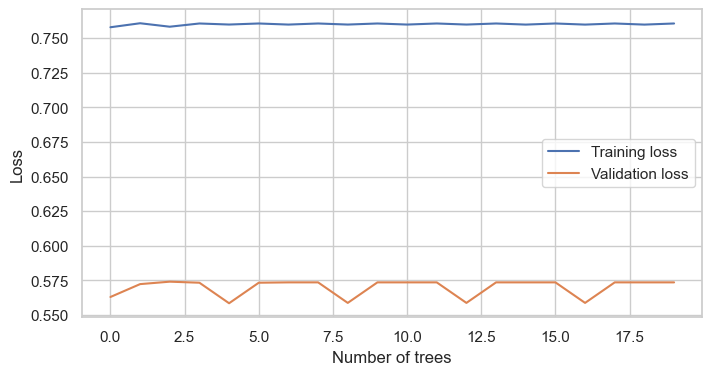

In [15]:
evaluate_grid(grid_base_xgb, X_val_base, y_val_base, 'Baseline')

Мы практически случайно предсказываем, не хорошо

### 2.2 Save Predict

In [ ]:
test = pd.merge(test_df, players_df.drop('map_name', axis=1), how='left', 
         left_on=['map_id', 'team1_id'], right_on=['map_id', 'team_id'])

test = pd.merge(test, players_df.drop('map_name', axis=1), how='left', 
         left_on=['map_id', 'team2_id'], right_on=['map_id', 'team_id'], suffixes=['_1', '_2'])
X_test = test.drop(['map_name'], axis=1).filter(regex='^((?!id).)*$', axis=1)


xgb_model = XGBClassifier(**grid_base_xgb.best_params_)
xgb_model.fit(X, y)

pred = xgb_model.predict(X_test)

pd.Series(pred).to_csv('predicts\predict_base_xgb.csv', index=False)

# 3. Feature Extraction

Первое, что хочется исправить это фичи. Интуитивно понятно, что оценивать игру команды по результатам игроков в данном виде не лучшая затея - у нас нет никакой градации, в какой последовательности стоят игроки, банально мы можем поменять p1 и p2 местами и вся модель потеряет смысл. Хочется перейти метрикам, которые бы отображали командное взаимодействие:

* Общие статистики по игрокам команды
* Доля сум значения первой команды, в общее значение данной статистики по двум командам
* Доля значения худшего / лучшего игрока в общее значение данной статистики по двум командам
* Отношение худшего / лучшего игрока 1 команды к х/л 2 команды
* Разница между статистиками команд

Худший/ лучший игрок определяется max или min значением, в зависимости от показателя игры

In [17]:
# Regex tamplates
tmp_dont_id = '^((?!id).)*$'
tmp_players_t1 = '^p\d_.*_1$'
tmp_players_t2 = '^p\d_.*_2$'
tmp_all_players = '^p\d_'

In [18]:
feature_names = set([f[3:] for f in players_df.filter(regex=tmp_all_players).filter(regex=tmp_dont_id).columns])
feature_names

{'assists_per_round',
 'damage_per_round',
 'deaths_per_round',
 'first_kill_in_won_rounds',
 'grenade_damage_per_round',
 'headshots',
 'kd_ratio',
 'kill_death',
 'kill_death_difference',
 'kill_round',
 'kills_per_round',
 'maps_played',
 'opening_kill_rating',
 'opening_kill_ratio',
 'rating',
 'rounds_played',
 'rounds_with_kills',
 'saved_by_teammate_per_round',
 'saved_teammates_per_round',
 'team_win_percent_after_first_kill',
 'total_deaths',
 'total_kills',
 'total_opening_deaths',
 'total_opening_kills'}

In [19]:
def get_statistics_for_team(save_df: pd.DataFrame, t_df: pd.DataFrame, number: int, f_name: str):
    save_df[f't{number}_mean_{f_name}'] = t_df.filter(like=f_name).mean(axis=1)
    save_df[f't{number}_max_{f_name}'] = t_df.filter(like=f_name).max(axis=1)
    save_df[f't{number}_min_{f_name}'] = t_df.filter(like=f_name).min(axis=1)
    save_df[f't{number}_std_{f_name}'] = t_df.filter(like=f_name).std(axis=1)
    save_df[f't{number}_sum_{f_name}'] = t_df.filter(like=f_name).sum(axis=1)
    
    save_df[f't{number}_range_{f_name}'] = save_df[f't{number}_max_{f_name}'] - save_df[f't{number}_min_{f_name}']
    
    
def generate_features(df: pd.DataFrame):
    df = df.copy()
    df_t1 = df.filter(regex=tmp_players_t1).filter(regex=tmp_dont_id)
    df_t2 = df.filter(regex=tmp_players_t2).filter(regex=tmp_dont_id)
    
    for f_name in feature_names:
        # Statistics
        for i_team, t_df in enumerate([df_t1, df_t2], start=1):
            get_statistics_for_team(df, t_df, i_team, f_name)
        
        # Total sum
        df[f'total_sum_{f_name}'] = df[f't1_sum_{f_name}'] + df[f't2_sum_{f_name}']
        
        # Share of the first team in the total value
        df[f'share_t1_in_{f_name}'] = df[f't1_sum_{f_name}'] / (df[f'total_sum_{f_name}'] + EPS)
        
        # Share of the best(worst) player in first team in the total value
        df[f'share_t1_max_in_{f_name}'] = df[f't1_max_{f_name}'] / (df[f'total_sum_{f_name}'] + EPS)
        df[f'share_t2_max_in_{f_name}'] = df[f't2_max_{f_name}'] / (df[f'total_sum_{f_name}'] + EPS)
        
        df[f'share_t1_min_in_{f_name}'] = df[f't1_min_{f_name}'] / (df[f'total_sum_{f_name}'] + EPS)
        df[f'share_t2_min_in_{f_name}'] = df[f't2_min_{f_name}'] / (df[f'total_sum_{f_name}'] + EPS)
        
        df[f'ratio_share_max_in_{f_name}'] = df[f'share_t1_max_in_{f_name}'] / (df[f'share_t2_max_in_{f_name}'] + EPS)
        df[f'ratio_share_min_in_{f_name}'] = df[f'share_t1_min_in_{f_name}'] / (df[f'share_t2_min_in_{f_name}'] + EPS)

        # Difference between teams in statistics
        for stat in ['mean', 'max', 'min', 'std', 'sum', 'range']:
            df[f'diff_{stat}_{f_name}'] = df[f't1_{stat}_{f_name}'] - df[f't2_{stat}_{f_name}']
    
    df = df.drop(['map_name'], axis=1).filter(regex=tmp_dont_id, axis=1)
    df = df.drop(df.filter(regex=tmp_players_t1).columns, axis=1)
    df = df.drop(df.filter(regex=tmp_players_t2).columns, axis=1)
    return df

Сразу хочется отсеить ненужные признаки, поэтому добавим рандомный

In [20]:
new_features = generate_features(features)
new_features['random_feature'] = np.random.random(size=new_features.shape[0])
new_features.shape

(713, 626)

In [21]:
# For check
new_features.filter(regex=f'^.*{"maps_played"}').transpose()

,0,1,2,3,4,5,6,7,8,9,...,703,704,705,706,707,708,709,710,711,712
t1_mean_maps_played,14.800000,15.200000,21.000000,17.400000,13.400000,23.200000,15.400000,18.800000,11.200000,16.800000,...,4.800000,11.000000,13.400000,8.600000,8.400000,19.000000,16.800000,30.400000,28.200000,15.000000
t1_max_maps_played,17.000000,17.000000,22.000000,18.000000,17.000000,28.000000,20.000000,20.000000,14.000000,20.000000,...,5.000000,20.000000,16.000000,9.000000,13.000000,20.000000,24.000000,31.000000,30.000000,17.000000
t1_min_maps_played,8.000000,12.000000,17.000000,15.000000,8.000000,5.000000,7.000000,17.000000,4.000000,6.000000,...,4.000000,8.000000,10.000000,7.000000,5.000000,17.000000,5.000000,29.000000,27.000000,9.000000
t1_std_maps_played,3.834058,2.489980,2.236068,1.341641,3.286335,10.183320,5.504544,1.643168,4.147288,6.058052,...,0.447214,5.049752,2.190890,0.894427,3.130495,1.414214,8.757854,0.894427,1.095445,3.464102
t1_sum_maps_played,74.000000,76.000000,105.000000,87.000000,67.000000,116.000000,77.000000,94.000000,56.000000,84.000000,...,24.000000,55.000000,67.000000,43.000000,42.000000,95.000000,84.000000,152.000000,141.000000,75.000000
t1_range_maps_played,9.000000,5.000000,5.000000,3.000000,9.000000,23.000000,13.000000,3.000000,10.000000,14.000000,...,1.000000,12.000000,6.000000,2.000000,8.000000,3.000000,19.000000,2.000000,3.000000,8.000000
t2_mean_maps_played,7.000000,30.400000,13.000000,15.200000,9.000000,11.400000,1.000000,14.400000,11.000000,16.000000,...,9.800000,6.600000,15.200000,6.000000,9.400000,17.200000,4.200000,17.000000,15.200000,17.400000
t2_max_maps_played,7.000000,32.000000,13.000000,17.000000,10.000000,13.000000,1.000000,16.000000,11.000000,18.000000,...,10.000000,9.000000,19.000000,6.000000,11.000000,18.000000,5.000000,17.000000,17.000000,21.000000
t2_min_maps_played,7.000000,24.000000,13.000000,10.000000,5.000000,11.000000,1.000000,14.000000,11.000000,10.000000,...,9.000000,6.000000,3.000000,6.000000,7.000000,16.000000,2.000000,17.000000,8.000000,12.000000
t2_std_maps_played,0.000000,3.577709,0.000000,3.033150,2.236068,0.894427,0.000000,0.894427,0.000000,3.464102,...,0.447214,1.341641,6.942622,0.000000,2.190890,1.095445,1.303840,0.000000,4.024922,4.929503


### 3.1 Train model

In [22]:
%%time
X_feat = new_features.drop(['who_win'], axis=1)
y_feat = new_features.who_win

X_train_feat, X_val_feat, y_train_feat, y_val_feat, grid_feat_xgb = train_xgb_with_grid(X_feat, y_feat, n_iter_random=N_PARAMS)

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits
CPU times: total: 1min 25s
Wall time: 37min 24s


New features best params:
{'gamma': 1,
 'learning_rate': 0.03,
 'max_depth': 5,
 'n_estimators': 50,
 'reg_alpha': 0.5,
 'reg_lambda': 0,
 'subsample': 0.5}
New features cross-val score: 0.5831834229949784
New features score: 0.6655770681418154


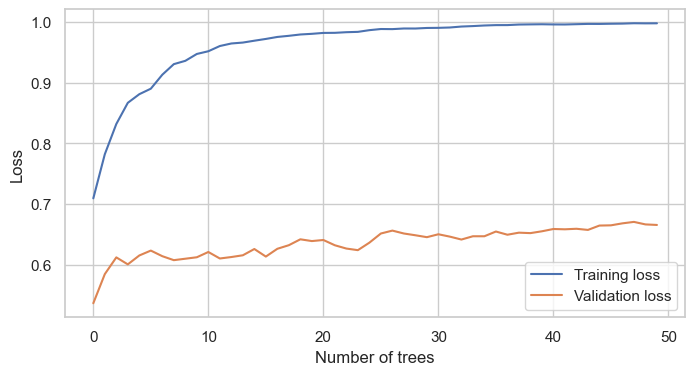

In [23]:
evaluate_grid(grid_feat_xgb, X_val_feat, y_val_feat, 'New features')

Видим прирост качества, попробуем отобрать признаки до рандомного

### 3.2 Feature Importance 

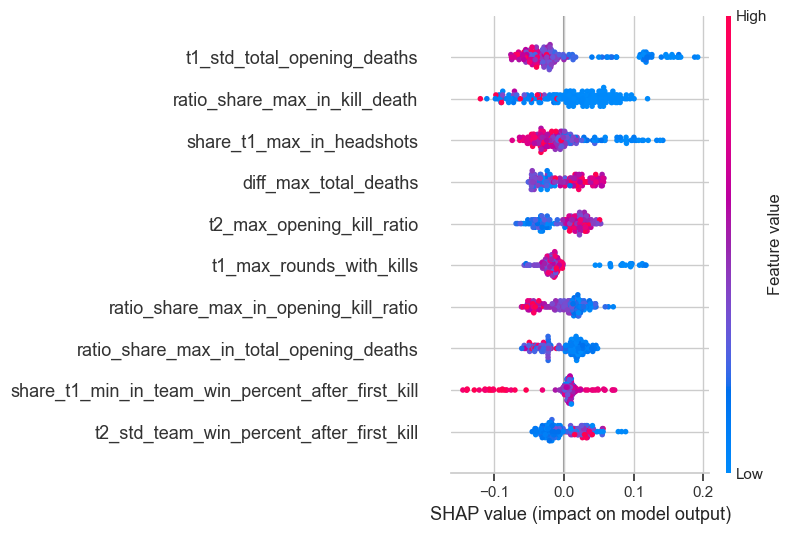

In [24]:
import shap

shap_test = shap.TreeExplainer(grid_feat_xgb.best_estimator_).shap_values(X_val_feat)
shap.summary_plot(shap_test, X_val_feat, max_display=10)

Интерпретация трех признаков:
1. Чем выше значение стандартного отклонения по open смертям в первой команды, тем выше вероятность победы второй команды
То есть, (скоее всего такая ситуация) если в первой команде есть игрок, который очень часто умирает на open (по сравнению с другими), то шансов у второй команды больше
2. Вторым признаком считается kd_ratio лучших игроков, сразу хочется сказать, что игроки как s1mple это +0.2 к метрике победы!)
3. Похожа на вторую, если в 1 команде есть игрок, который ставит супер много хедов (по сравнению со всеми игроками), то и шансов у 1 команды больше

In [25]:
def get_feature_importance(_shap_test, val):
    vals= np.abs(_shap_test).mean(0)

    feature_importance = pd.DataFrame(list(zip(val.columns, vals)), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
    feature_importance = feature_importance.reset_index(drop=True)
    return feature_importance

In [26]:
feature_importance = get_feature_importance(shap_test, X_val_feat)
feature_importance

,col_name,feature_importance_vals
0,t1_std_total_opening_deaths,0.051851
1,ratio_share_max_in_kill_death,0.047250
2,share_t1_max_in_headshots,0.033857
3,diff_max_total_deaths,0.029745
4,t2_max_opening_kill_ratio,0.027669
...,...,...
620,t1_std_kill_death,0.000000
621,t1_sum_kill_death,0.000000
622,share_t1_in_total_opening_deaths,0.000000
623,t1_range_kill_death,0.000000


Удалим признаки ниже рандомного

In [27]:
feature_importance = feature_importance.iloc[:feature_importance[feature_importance.col_name == 'random_feature'].index[0]]
feature_importance.shape

(126, 2)

### 3.3 Training with clear features

Будем обучать модель на отобранных признаках, при этом удаля признаки, значение которых равно 0 (по шепли)

In [28]:
top_features = feature_importance[feature_importance.feature_importance_vals > 0].col_name.values
len(top_features)

126

In [29]:
%%time

best_features = top_features
best_model = None
best_score = 0

last_f = top_features.tolist() + [None]

i = 1
while len(last_f) != len(top_features):
    print(f'Start {i}')
    last_f = top_features
    
    clear_features = new_features.loc[:, top_features]
    y = new_features.who_win
    X_train_step, X_val_step, y_train_step, y_val_step, grid_clear_xgb = train_xgb_with_grid(
        clear_features, y, n_iter_random=N_PARAMS)
    
    score = roc_auc_score(y_val_step, grid_clear_xgb.best_estimator_.predict_proba(X_val_step)[:, 1])
    
    print('Score:', score)
    
    shap_test = shap.TreeExplainer(grid_clear_xgb.best_estimator_).shap_values(X_val_step)
    new_feature_importance = get_feature_importance(shap_test, X_val_step)
    
    top_features = new_feature_importance[new_feature_importance.feature_importance_vals > 0].col_name.values
    
    print(f'Amount {len(top_features)} params')
    
    if score > best_score:
        best_score = grid_clear_xgb.best_score_
        best_features = top_features
        best_model = grid_clear_xgb
        
        X_train_clear = X_train_step
        X_val_clear = X_val_step
        y_train_clear = y_train_step
        y_val_clear = y_val_step

    i += 1

Start 1
Fitting 3 folds for each of 5400 candidates, totalling 16200 fits
Score: 0.6029670605984411
Amount 125 params
Start 2
Fitting 3 folds for each of 5400 candidates, totalling 16200 fits
Score: 0.6179280864973599
Amount 122 params
Start 3
Fitting 3 folds for each of 5400 candidates, totalling 16200 fits
Score: 0.6450842343474981
Amount 121 params
Start 4
Fitting 3 folds for each of 5400 candidates, totalling 16200 fits
Score: 0.6179280864973598
Amount 121 params
CPU times: total: 1min 32s
Wall time: 33min 1s


In [61]:
len(best_features)

121

Clear features best params:
{'gamma': 1,
 'learning_rate': 0.03,
 'max_depth': 5,
 'n_estimators': 50,
 'reg_alpha': 0.5,
 'reg_lambda': 0.1,
 'subsample': 0.5}
Clear features cross-val score: 0.6202856496873483
Clear features score: 0.6450842343474981


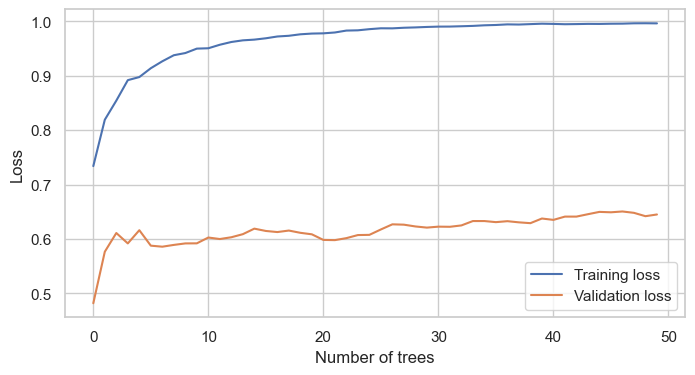

In [30]:
evaluate_grid(best_model, X_val_clear, y_val_clear, 'Clear features')

Качество на валидации чуть ухудшилось, но видно, что модель все еще устойчивая (трейн почти сто процентный без падения качества на валидации), значит, возможно, мы уменьшили variance. Если провести отбор признаков еще тщательнее, например, с помощью метода агрегации коррелирующих признаков с помощью понижения размерности, то, возможно, можно будет добиться лучшего качества.

### 3.4 Save predict

In [31]:
test = pd.merge(test_df, players_df.drop('map_name', axis=1), how='left', 
         left_on=['map_id', 'team1_id'], right_on=['map_id', 'team_id'])

test = pd.merge(test, players_df.drop('map_name', axis=1), how='left', 
         left_on=['map_id', 'team2_id'], right_on=['map_id', 'team_id'], suffixes=['_1', '_2'])

X_test = generate_features(test)
X_test = X_test.loc[:, best_features]

clear_features = new_features.loc[:, best_features]
X = clear_features
y = new_features.who_win

xgb_model = XGBClassifier(**grid_clear_xgb.best_params_)
xgb_model.fit(X, y)

pred = xgb_model.predict(X_test)

pd.Series(pred).to_csv('predicts\predict_features_xgb.csv', index=False)

# 4. Two classifiers

Обучим два классификатора, один предсказывает вероятность победы первой команды, второй для другой. На получившихся значениях обучим логрег в качестве метамодели

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [33]:
clear_features = new_features.loc[:, best_features]
X_two = clear_features
y_2 = new_features.who_win
y_1 = (y_2 == 0).map({True: 1, False: 0})

In [34]:
X_train_1, X_val_1, y_train_1, y_val_1, grid_xgb_1 = train_xgb_with_grid(X_two, y_1, n_iter_random=N_PARAMS) 

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits


In [35]:
y_train_2 = y_2.iloc[y_train_1.index.values]
y_val_2 = y_2.iloc[list(set(y_2.index) - set(y_train_2.index))]

In [36]:
X_train_2, X_val_2, y_train_2, y_val_2, grid_xgb_2 = train_xgb_with_grid(n_iter_random=N_PARAMS, 
                                                    X_train=X_train_1, y_train=y_train_2, X_val=X_val_1, y_val=y_val_2) 

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits


In [37]:
X_train_1.index

Int64Index([402, 323, 610, 437, 588, 286, 455, 478, 669, 338,
            ...
            183, 122, 172,  22, 265,  96, 178, 150, 623, 224],
           dtype='int64', length=534)

In [38]:
X_train_2.index

Int64Index([402, 323, 610, 437, 588, 286, 455, 478, 669, 338,
            ...
            183, 122, 172,  22, 265,  96, 178, 150, 623, 224],
           dtype='int64', length=534)

First xgb best params:
{'gamma': 1,
 'learning_rate': 0.03,
 'max_depth': 3,
 'n_estimators': 50,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 1}
First xgb cross-val score: 0.622372543229537
First xgb score: 0.5963037465426201


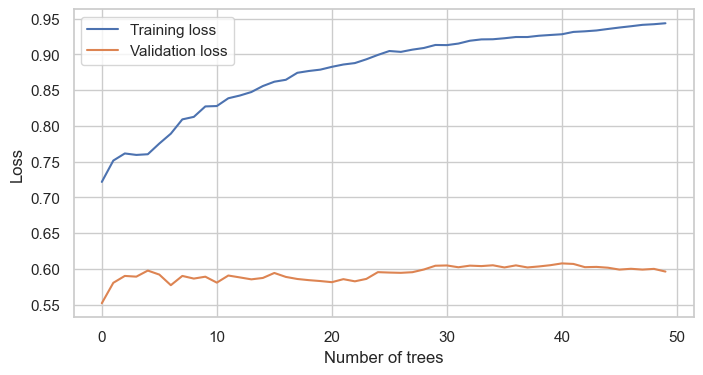

In [39]:
evaluate_grid(grid_xgb_1, X_val_1, y_val_1, 'First xgb')

Second xgb best params:
{'gamma': 1,
 'learning_rate': 0.03,
 'max_depth': 3,
 'n_estimators': 50,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 1}
Second xgb cross-val score: 0.622372543229537
Second xgb score: 0.4827759617802363


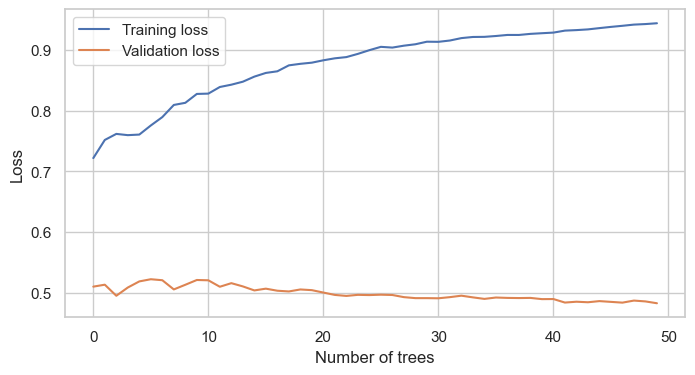

In [40]:
evaluate_grid(grid_xgb_2, X_val_2, y_val_2, 'Second xgb')

In [41]:
X_train_lr = pd.DataFrame(index=X_train_1.index, 
                          data={
                'predict_1': grid_xgb_1.best_estimator_.predict_proba(X_train_1)[:, 1],
                'predict_2': grid_xgb_2.best_estimator_.predict_proba(X_train_2)[:, 1]
            })
X_train_lr

,predict_1,predict_2
402,0.671591,0.328409
323,0.419996,0.580004
610,0.364420,0.635580
437,0.564644,0.435356
588,0.384829,0.615171
...,...,...
96,0.370295,0.629705
178,0.473415,0.526585
150,0.532812,0.467188
623,0.567682,0.432318


In [42]:
X_val_lr = pd.DataFrame(index=X_val_1.index, 
                          data={
                'predict_1': grid_xgb_1.best_estimator_.predict_proba(X_val_1)[:, 0],
                'predict_2': grid_xgb_2.best_estimator_.predict_proba(X_val_2)[:, 1]
            })
X_val_lr

,predict_1,predict_2
620,0.483086,0.483086
474,0.577167,0.577167
441,0.364843,0.364843
91,0.358633,0.358633
434,0.423318,0.423318
...,...,...
564,0.441682,0.441682
240,0.371428,0.371428
532,0.623413,0.623413
518,0.617718,0.617718


In [43]:
y_train_lr = y_train_2.copy()
y_val_lr = y_val_2.copy()

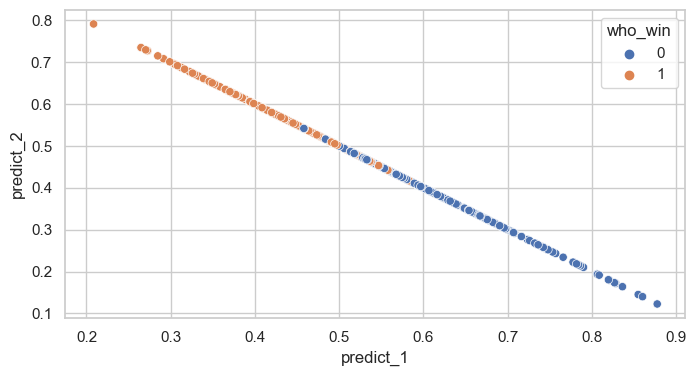

In [44]:
sns.scatterplot(data=X_train_lr, x='predict_1', y='predict_2', hue=y_train_lr);

In [45]:
scaler = StandardScaler()
X_train_lr_sc = scaler.fit_transform(X_train_lr)
X_val_lr_sc = scaler.transform(X_val_lr)

In [46]:
np.linspace(-1, 1)

array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
       -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
       -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
       -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
       -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
        0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
        0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.3877551 ,
        0.42857143,  0.46938776,  0.51020408,  0.55102041,  0.59183673,
        0.63265306,  0.67346939,  0.71428571,  0.75510204,  0.79591837,
        0.83673469,  0.87755102,  0.91836735,  0.95918367,  1.        ])

In [47]:
lr_params = {
    'C': list(np.logspace(-4, 4, 50)),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}

In [48]:
lr = LogisticRegression(n_jobs=-1)
grid_lr = GridSearchCV(lr, lr_params, verbose=10, n_jobs=-1).fit(X_train_lr_sc, y_train_lr)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [49]:
roc_auc_score(y_val_lr, grid_lr.best_estimator_.predict_proba(X_val_lr_sc)[:, 1])

0.5269675634900679

Стекинг моделей не дал хороших результатов( 

Пробовал в качестве мета-модели: xgb, rf

# 5. + Feature Extraction

Хотелось бы получать информацию, используя временные ряды. Т.к. даты игр не даны, следующие доп признаки строятся на предположении, что map_id возрастает в соответствии с возрастанием даты игры.

Исходя из этого хочу получить признаки:
* количество игр команды на этой карте до нее
* были ли смены игроков по сравнению с прошлой картой
* дифф метрик от предыдущего значения (вырос ли скилл)

In [50]:
def generate_all_feature(df: pd.DataFrame):
    n_f = generate_features(df)
    all_f = n_f.join(df.drop('who_win', axis=1))
    
    all_f = all_f.sort_values('map_id', axis=0)

    
    # Get diff from prev game
    for col in all_f.filter(regex=tmp_dont_id).filter(like='t1').columns:
        all_f[f'diff_prev_{col}_t1'] = all_f[col] - all_f.groupby('team_id_1')[col].shift().fillna(0)
        
    for col in all_f.filter(regex=tmp_dont_id).filter(like='t2').columns:
        all_f[f'diff_prev_{col}_t2'] = all_f[col] - all_f.groupby('team_id_2')[col].shift().fillna(0)
    
    # Extra tables
    all_f['ones'] = 1
    team_1_pivot = all_f.pivot(values='ones', index=['team_id_1', 'map_name'], columns='map_id').cumsum(axis=1).transpose()
    team_2_pivot = all_f.pivot(values='ones', index=['team_id_2', 'map_name'], columns='map_id').cumsum(axis=1).transpose()
    
    # Get count game on this map before
    same_maps_before_t1 = []
    same_maps_before_t2 = []
    for m_id, t_id_1, t_id_2, m_n in all_f.loc[:, ['map_id', 'team_id_1', 'team_id_2', 'map_name']].values:
        same_maps_before_t1.append(team_1_pivot.loc[m_id][t_id_1][m_n] - 1)
        same_maps_before_t2.append(team_2_pivot.loc[m_id][t_id_2][m_n] - 1)
        
    
    all_f['same_maps_before_t1'] = same_maps_before_t1
    all_f['same_maps_before_t2'] = same_maps_before_t2
    
    
    # Player change
    all_f['all_players_id_t1'] = all_f.filter(regex='p\d_id_1').astype('str').agg(' '.join,  axis=1)
    all_f['all_players_id_t2'] = all_f.filter(regex='p\d_id_2').astype('str').agg(' '.join,  axis=1)

    all_f['prev_all_players_id_t1'] = all_f.groupby(['team_id_1'])['all_players_id_t1']\
                                                    .shift().fillna(all_f['all_players_id_t1'])
    
    all_f['prev_all_players_id_t2'] = all_f.groupby(['team_id_2'])['all_players_id_t2']\
                                                    .shift().fillna(all_f['all_players_id_t2'])

    all_f['player_change_t1'] = all_f.apply(
                lambda x: not all(id in x.prev_all_players_id_t1.split() for id in x.all_players_id_t1.split()), axis=1)\
                .map({True: 1, False: 0})

    all_f['player_change_t2'] = all_f.apply(
                lambda x: not all(id in x.prev_all_players_id_t2.split() for id in x.all_players_id_t2.split()), axis=1) \
                .map({True: 1, False: 0})
    
    all_f.drop(['all_players_id_t1', 'all_players_id_t2', 'prev_all_players_id_t1', 'prev_all_players_id_t2'], axis=1, inplace=True)
    
    target = all_f.who_win
    all_f.drop(['who_win', 'ones', 'map_name', 'map_id'], axis=1, inplace=True)
    all_f = all_f.drop(df.filter(regex=tmp_players_t1).columns, axis=1)
    all_f = all_f.drop(df.filter(regex=tmp_players_t2).columns, axis=1)
    
    return all_f, target

In [51]:
X_all_feat, y_all_feat = generate_all_feature(features)

In [52]:
X_all_feat.shape

(713, 1040)

In [53]:
X_all_feat.head()

,t1_mean_opening_kill_rating,t1_max_opening_kill_rating,t1_min_opening_kill_rating,t1_std_opening_kill_rating,t1_sum_opening_kill_rating,t1_range_opening_kill_rating,t2_mean_opening_kill_rating,t2_max_opening_kill_rating,t2_min_opening_kill_rating,t2_std_opening_kill_rating,...,diff_prev_t2_min_first_kill_in_won_rounds_t2,diff_prev_t2_std_first_kill_in_won_rounds_t2,diff_prev_t2_sum_first_kill_in_won_rounds_t2,diff_prev_t2_range_first_kill_in_won_rounds_t2,diff_prev_share_t2_max_in_first_kill_in_won_rounds_t2,diff_prev_share_t2_min_in_first_kill_in_won_rounds_t2,same_maps_before_t1,same_maps_before_t2,player_change_t1,player_change_t2
78,0.998,1.14,0.92,0.094710,4.99,0.22,1.052,1.35,0.90,0.182675,...,9.7,5.393051,76.0,14.1,0.164251,0.066943,0.0,0.0,0,0
173,1.000,1.08,0.93,0.057879,5.00,0.15,1.036,1.18,0.84,0.175014,...,7.5,4.290921,69.6,11.8,0.141185,0.054865,0.0,0.0,1,0
294,1.008,1.21,0.85,0.143944,5.04,0.36,1.080,1.38,0.75,0.243721,...,6.0,7.546324,74.9,18.5,0.165765,0.040595,0.0,0.0,0,0
435,1.148,1.42,0.89,0.196647,5.74,0.53,1.030,1.16,0.85,0.112472,...,6.7,4.919045,75.6,13.0,0.133198,0.045301,0.0,0.0,0,0
395,0.954,1.28,0.71,0.227662,4.77,0.57,1.056,1.20,0.85,0.139212,...,9.7,3.869496,75.7,10.2,0.142041,0.069236,0.0,0.0,0,0


In [54]:
true_ids = X_all_feat.index

### 5.1 Train model

In [55]:
# Т.к. временные ряды, то нельзя обучаться на данных из будущего

X_train_all_feat = X_all_feat.iloc[:600]
X_val_all_feat = X_all_feat.iloc[600:]

y_train_all_feat = y_all_feat.iloc[:600]
y_val_all_feat = y_all_feat.iloc[600:]

tcv = TimeSeriesSplit(n_splits=N_FOLDS)

In [56]:
%%time

X_train_all_feat, X_val_all_feat, y_train_all_feat, y_val_all_feat, grid_all_feat_xgb = train_xgb_with_grid(
                                    cv=tcv, X_train=X_train_all_feat, y_train=y_train_all_feat, X_val=X_val_all_feat, 
                                    y_val=y_val_all_feat, n_iter_random=N_PARAMS)

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits
CPU times: total: 1min 33s
Wall time: 55min 37s


Time series features best params:
{'gamma': 0,
 'learning_rate': 0.03,
 'max_depth': 3,
 'n_estimators': 20,
 'reg_alpha': 0.1,
 'reg_lambda': 0,
 'subsample': 0.5}
Time series features cross-val score: 0.5707249316943721
Time series features score: 0.7608418367346939


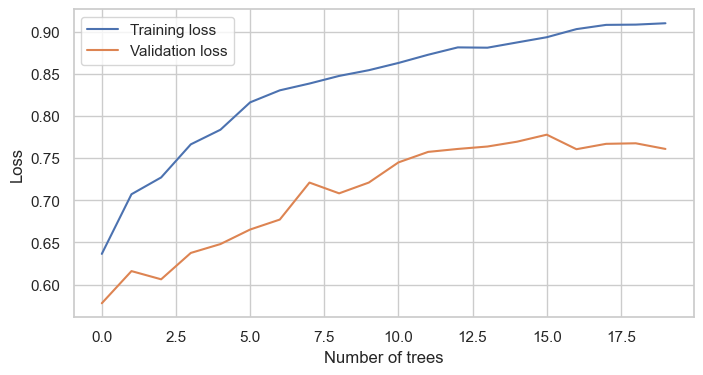

In [57]:
evaluate_grid(grid_all_feat_xgb, X_val_all_feat, y_val_all_feat, 'Time series features')

Данные фичи позволили сильно поднять качество модели, но, надеюсь, я не обучался на данных из будущего)

### 5.2 Features

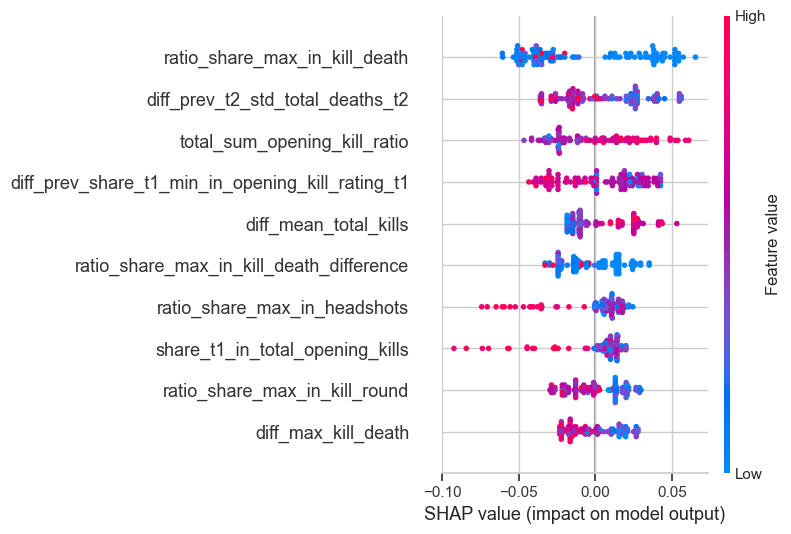

In [60]:
shap_test_all_feat = shap.TreeExplainer(grid_all_feat_xgb.best_estimator_).shap_values(X_val_all_feat)
shap.summary_plot(shap_test_all_feat, X_val_all_feat, max_display=10)

В том три фичи попала: прирост std 2 команды с прошлой игры по открывающим смертям. Если 2к стала чаще отдаваться на опен, то победит первая команда

### 5.3 Save predict

In [58]:
test = pd.merge(test_df, players_df.drop('map_name', axis=1), how='left', 
         left_on=['map_id', 'team1_id'], right_on=['map_id', 'team_id'])

test = pd.merge(test, players_df.drop('map_name', axis=1), how='left', 
         left_on=['map_id', 'team2_id'], right_on=['map_id', 'team_id'], suffixes=['_1', '_2'])

test['who_win'] = 1

X_test, y_test = generate_all_feature(test)

X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)

In [59]:
xgb_model = XGBClassifier(**grid_all_feat_xgb.best_params_)
xgb_model.fit(X_all_feat, y_all_feat)

pred = xgb_model.predict(X_test)

pd.Series(pred).to_csv('predicts\predict_time_series_xgb.csv', index=False)